# Importing required Libraries

In [1]:
from datetime import datetime
import os
from os import listdir
from os.path import isfile, join

import librosa
import librosa.display

import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from scipy import signal
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

# Importing Files

In [2]:
pwd

'/Users/ad/Downloads/FYP'

In [3]:
mypath ='/Users/ad/Downloads/FYP/audio_and_txt_files/'
filenames = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f.endswith('.wav'))]

In [4]:
p_id_in_file = [] # patient IDs corresponding to each file
for name in filenames:
    p_id_in_file.append(int(name[:3]))

p_id_in_file = np.array(p_id_in_file)

# Creating functions for data Augmentation

In [5]:
def shift(data, shift_max=2, shift_direction='right'):
    shift = np.random.randint(22050 * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif self.shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    audio, sample_rate = librosa.load(data, res_type='kaiser_fast', duration=20) 
    b, a = signal.butter(6, [100/sample_rate,5000/sample_rate], 'bandpass', analog=False)
    f = signal.filtfilt(b, a, audio)
    augmented_data = np.roll(f, shift)
    # Set to silence for heading/ tailing
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
    mfccs = librosa.feature.mfcc(y=augmented_data, sr=sample_rate, n_mfcc=40)
    pad_width = max_pad_len - mfccs.shape[1]
    mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    
    return mfccs

In [6]:
def pitch(data, pitch_factor=2):
    audio, sample_rate = librosa.load(data, res_type='kaiser_fast', duration=20) 
    audio=librosa.effects.pitch_shift(audio, sample_rate, pitch_factor)
    b, a = signal.butter(6, [100/sample_rate,5000/sample_rate], 'bandpass', analog=False)
    f = signal.filtfilt(b, a, audio)
    mfccs = librosa.feature.mfcc(y=f, sr=sample_rate, n_mfcc=40)
    pad_width = max_pad_len - mfccs.shape[1]
    mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfccs

In [7]:
def speed(data, speed_factor=2):
    audio, sample_rate = librosa.load(data, res_type='kaiser_fast', duration=20)
    audio=librosa.effects.time_stretch(audio, speed_factor)
    b, a = signal.butter(6, [100/sample_rate,5000/sample_rate], 'bandpass', analog=False)
    f = signal.filtfilt(b, a, audio)
    mfccs = librosa.feature.mfcc(y=f, sr=sample_rate, n_mfcc=40)
    pad_width = max_pad_len - mfccs.shape[1]
    mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfccs

In [8]:
max_pad_len = 862 # to make the length of all MFCC equal

def extract_features(file_name):
    """
    This function takes in the path for an audio file as a string, loads it, and returns the MFCC
    of the audio"""
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=20) 
        b, a = signal.butter(6, [100/sample_rate,5000/sample_rate], 'bandpass', analog=False)
        f = signal.filtfilt(b, a, audio)
        mfccs = librosa.feature.mfcc(y=f, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [9]:
filepaths = [join(mypath, f) for f in filenames] # full paths of files

In [10]:
p_diag = pd.read_csv('/Users/ad/Downloads/FYP/patient_diagnosis.csv',header=None) # patient diagnosis file

In [11]:
labels = np.array([p_diag[p_diag[0] == x][1].values[0] for x in p_id_in_file]) # labels for audio files

# Extracting Features

In [ ]:
features = [] 

# Iterate through each sound file and extract the features
for file_name in filepaths:
    data = extract_features(file_name)
    features.append(data)

print('Finished feature extraction from ', len(features), ' original files')

# Adding Augmented Files to data set

In [13]:
labels=np.array(labels).tolist()
for i in range (0,920):
    if labels[i]!='COPD':
        p=shift(filepaths[i], 2, 'right')
        q=pitch(filepaths[i],2)
        r=speed(filepaths[i],1.2)
        features.append(p)
        features.append(q)
        features.append(r)
        for j in range(0,3):
            labels.append(labels[i])
print('Finished feature extraction from ', len(features)-920, 'augmented files')

Finished feature extraction from  381 augmented files


In [14]:
features=np.array(features)
labels=np.array(labels)

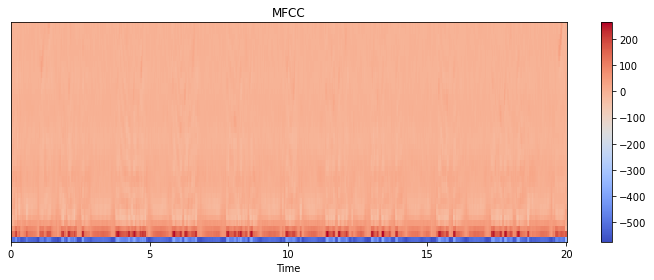

In [15]:
#plot an MFCC
plt.figure(figsize=(10, 4))
librosa.display.specshow(features[100], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [16]:
# print class counts
unique_elements, counts_elements = np.unique(labels, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[['Asthma' 'Bronchiectasis' 'Bronchiolitis' 'COPD' 'Healthy' 'LRTI'
  'Pneumonia' 'URTI']
 ['4' '64' '52' '793' '140' '8' '148' '92']]


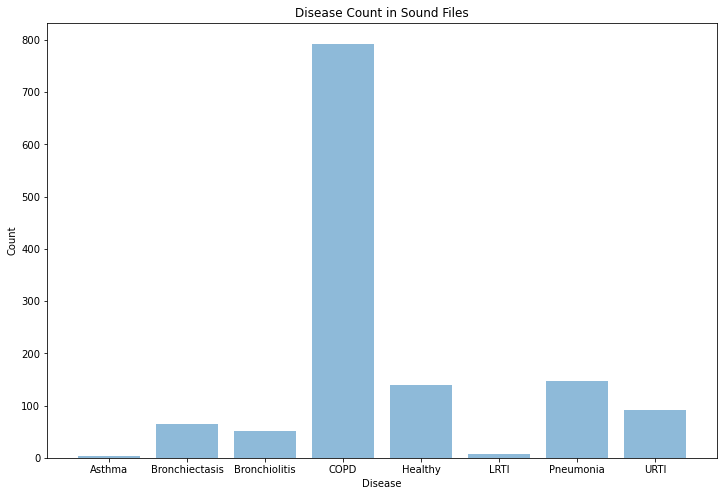

In [17]:
# plot class counts
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(12,8))
plt.bar(unique_elements, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Disease Count in Sound Files')
plt.show()

# Remove the data with least cases

In [18]:
features1 = np.delete(features, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0) 

labels1 = np.delete(labels, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

# Designing Neural Network

In [19]:
# One-hot encode labels
le = LabelEncoder()
i_labels = le.fit_transform(labels1)
i_labels=np.array(i_labels).tolist()


In [20]:
for i in range(0,1289):
    if i_labels[i] ==2:
        i_labels[i]= 0
    elif i_labels[i]==3:
        i_labels[i]= 1
    else:
        i_labels[i]=2


In [21]:
i_labels=np.array(i_labels)
oh_labels = to_categorical(i_labels)

In [22]:
oh_labels[0]

array([0., 0., 1.], dtype=float32)

In [23]:
# add channel dimension for CNN
features1 = np.reshape(features1, (*features1.shape,1))

In [24]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(features1, oh_labels, stratify=oh_labels, 
                                                    test_size=0.2, random_state = 42)

In [25]:
y_train[0]

array([1., 0., 0.], dtype=float32)

In [26]:
num_rows = 40
num_columns = 862
num_channels = 1

num_labels = oh_labels.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))


model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=96, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))


model.add(Conv2D(filters=96, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))


model.add(GlobalAveragePooling2D())
model.add(Dense(256))
model.add(Dropout(0.6))
model.add(Dense(128))
model.add(Dropout(0.3))
model.add(Dense(64))
model.add(Dropout(0.15))
model.add(Dense(32))
model.add(Dropout(0.075))
model.add(Dense(16))
model.add(Dropout(0.0325))
model.add(Dense(8))
model.add(Dense(num_labels, activation='softmax'))

In [27]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [28]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 861, 64)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 430, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 429, 64)       16448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 214, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 213, 96)        24672     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 106, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 105, 96)        3

# Training the model

In [29]:
# train model
num_epochs = 120
num_batch_size = 128

callbacks = [
    ModelCheckpoint(
        filepath='mymodel2_{epoch:02d}.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

history=model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)


Epoch 1/120
9/9 [==============================] - 18s 2s/step - loss: 9.4638 - accuracy: 0.4869 - val_loss: 1.4293 - val_accuracy: 0.6899

Epoch 00001: val_accuracy improved from -inf to 0.68992, saving model to mymodel2_01.h5
Epoch 2/120
9/9 [==============================] - 18s 2s/step - loss: 1.5024 - accuracy: 0.6275 - val_loss: 0.5743 - val_accuracy: 0.7597

Epoch 00002: val_accuracy improved from 0.68992 to 0.75969, saving model to mymodel2_02.h5
Epoch 3/120
9/9 [==============================] - 60s 7s/step - loss: 0.7960 - accuracy: 0.6741 - val_loss: 0.5719 - val_accuracy: 0.7403

Epoch 00003: val_accuracy did not improve from 0.75969
Epoch 4/120
9/9 [==============================] - 18s 2s/step - loss: 0.6828 - accuracy: 0.6906 - val_loss: 0.5423 - val_accuracy: 0.7403

Epoch 00004: val_accuracy did not improve from 0.75969
Epoch 5/120
9/9 [==============================] - 19s 2s/step - loss: 0.6248 - accuracy: 0.6964 - val_loss: 0.5313 - val_accuracy: 0.7752

Epoch 00005

9/9 [==============================] - 18s 2s/step - loss: 0.2667 - accuracy: 0.8855 - val_loss: 0.3257 - val_accuracy: 0.8682

Epoch 00082: val_accuracy did not improve from 0.91860
Epoch 83/120
9/9 [==============================] - 18s 2s/step - loss: 0.2531 - accuracy: 0.8991 - val_loss: 0.4437 - val_accuracy: 0.8217

Epoch 00083: val_accuracy did not improve from 0.91860
Epoch 84/120
9/9 [==============================] - 18s 2s/step - loss: 0.2767 - accuracy: 0.8894 - val_loss: 0.2839 - val_accuracy: 0.8721

Epoch 00084: val_accuracy did not improve from 0.91860
Epoch 85/120
9/9 [==============================] - 18s 2s/step - loss: 0.1716 - accuracy: 0.9243 - val_loss: 0.2526 - val_accuracy: 0.8992

Epoch 00085: val_accuracy did not improve from 0.91860
Epoch 86/120
9/9 [==============================] - 18s 2s/step - loss: 0.1297 - accuracy: 0.9486 - val_loss: 0.2474 - val_accuracy: 0.8992

Epoch 00086: val_accuracy did not improve from 0.91860
Epoch 87/120
9/9 [===============

In [30]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9709020256996155
Testing Accuracy:  0.8914728760719299


In [31]:
preds = model.predict(x_test) # label scores 

classpreds = np.argmax(preds, axis=1) # predicted classes 

y_testclass = np.argmax(y_test, axis=1) # true classes

n_classes=3 # number of classes

# Summarize History for Loss

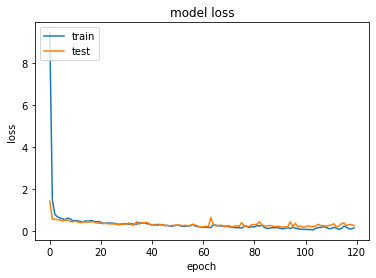

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize History for accuracy

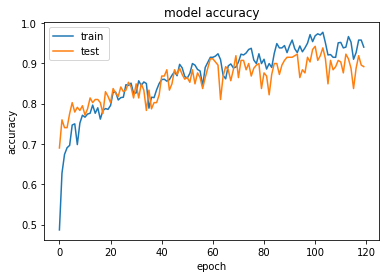

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [35]:
c_names = ['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI']
c_names2=["Chronic",'Healthy','Non Chronic']

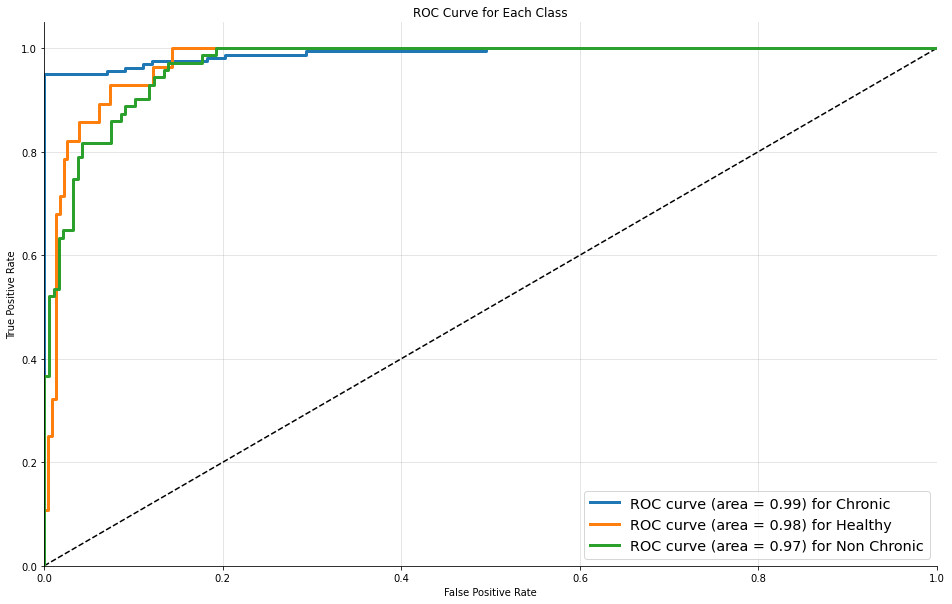

In [36]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names2[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [37]:
# Classification Report
print(classification_report(y_testclass, classpreds, target_names=c_names2))

              precision    recall  f1-score   support

     Chronic       0.91      0.97      0.94       159
     Healthy       0.81      0.75      0.78        28
 Non Chronic       0.89      0.76      0.82        71

    accuracy                           0.89       258
   macro avg       0.87      0.83      0.85       258
weighted avg       0.89      0.89      0.89       258



In [38]:
# Confusion Matrix
print(confusion_matrix(y_testclass, classpreds))

[[155   0   4]
 [  4  21   3]
 [ 12   5  54]]
